In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 准备数据集
df = pd.read_csv('Data.csv', index_col=0) # 导入数据
arr = df.values # Pandas 对象退化为 NumPy 数组
arr = arr.astype(np.float32) # 转为 float32 类型数组
ts = torch.tensor(arr) # 数组转为张量
ts = ts.to('cuda') # 把训练集搬到 cuda 上
ts.shape

torch.Size([759, 9])

In [4]:
# 划分训练集与测试集
train_size = int(len(ts) * 0.7) # 训练集的样本数量
test_size = len(ts) - train_size # 测试集的样本数量
ts = ts[ torch.randperm( ts.size(0) ) , : ] # 打乱样本的顺序
train_Data = ts[ : train_size , : ] # 训练集样本
test_Data = ts[ train_size : , : ] # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([531, 9]), torch.Size([228, 9]))

In [5]:
class DNN(nn.Module):
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential( # 按顺序搭建各层
            nn.Linear(8, 32), nn.Sigmoid(), # 第 1 层：全连接层
            nn.Linear(32, 8), nn.Sigmoid(), # 第 2 层：全连接层
            nn.Linear(8, 4), nn.Sigmoid(), # 第 3 层：全连接层
            nn.Linear(4, 1), nn.Sigmoid() # 第 4 层：全连接层
        )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [6]:
model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [7]:
# 损失函数的选择
# loss_fn = nn.MSELoss()  
loss_fn = nn.BCELoss(reduction='mean') # CELoss中输入的张的范围必须在[0.0,1.0]之间

In [8]:
# 优化算法的选择
learning_rate = 0.005 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

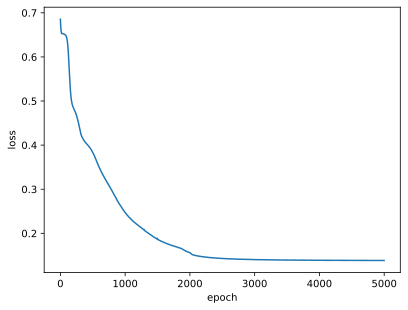

In [9]:
# 训练网络
epochs = 5000
losses = [] # 记录损失函数变化的列表
# 给训练集划分输入与输出
X = train_Data[ : , : -1 ] # 前 8 列为输入特征
Y = train_Data[ : , -1 ].reshape((-1,1)) # 后 1 列为输出特征
# 此处的.reshape((-1,1))将一阶张量升级为二阶张量
for epoch in range(epochs):
    Pred = model(X) # 一次前向传播（批量）
    loss = loss_fn(Pred, Y) # 计算损失函数
    losses.append(loss.item()) # 记录损失函数的变化
    optimizer.zero_grad() # 清理上一轮滞留的梯度
    loss.backward() # 一次反向传播
    optimizer.step() # 优化内部参数
 
Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
# 测试网络
# 给测试集划分输入与输出
X = test_Data[ : , : -1 ] # 前 8 列为输入特征
Y = test_Data[ : , -1 ].reshape((-1,1)) # 后 1 列为输出特征
with torch.no_grad(): # 该局部关闭梯度计算功能
    Pred = model(X) # 一次前向传播（批量）
    Pred[Pred>=0.5] = 1
    Pred[Pred<0.5] = 0
    correct = torch.sum( (Pred == Y) ) # 预测正确的样本
    total = Y.size(0) # 全部的样本数量
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 70.1754379272461 %


In [11]:
# 测试网络
# 给测试集划分输入与输出
X = test_Data[ : , : -1 ] # 前 8 列为输入特征
Y = test_Data[ : , -1 ].reshape((-1,1)) # 后 1 列为输出特征
with torch.no_grad(): # 该局部关闭梯度计算功能
    Pred = model(X) # 一次前向传播（批量）
    Pred[Pred>=0.5] = 1
    Pred[Pred<0.5] = 0
    print(Pred.type(), Y.type())   
    print(Pred.shape, Y.shape)
    print((Pred == Y).type(), (Pred == Y).all(1).type())   
    print((Pred == Y).shape, (Pred == Y).all(1).shape)      
    correct = torch.sum( (Pred == Y).all(1) ) # 预测正确的样本
    total = Y.size(0) # 全部的样本数量
print(f'测试集精准度: {100*correct/total} %')

torch.cuda.FloatTensor torch.cuda.FloatTensor
torch.Size([228, 1]) torch.Size([228, 1])
torch.cuda.BoolTensor torch.cuda.BoolTensor
torch.Size([228, 1]) torch.Size([228])
测试集精准度: 70.1754379272461 %
